In [1]:
import ranx
from ranx import Qrels, Run, evaluate
import torch.utils
from data6 import GraphDatasetEdgesAndNodesWithNegativeSamplesTest, HarderGraphDatasetEdgesAndNodesWithNegativeSamplesTest
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

test_dataset = GraphDatasetEdgesAndNodesWithNegativeSamplesTest(root="graph_dataset_edges_and_nodes_negative_samples_test")
test_dataset_harder = HarderGraphDatasetEdgesAndNodesWithNegativeSamplesTest(root="harder_graph_dataset_edges_and_nodes_negative_samples_test")
test_dataset_larger = GraphDatasetEdgesAndNodesWithNegativeSamplesTest(root="graph_dataset_edges_and_nodes_negative_samples_test_large")
test_dataset_harder_larger = HarderGraphDatasetEdgesAndNodesWithNegativeSamplesTest(root="harder_graph_dataset_edges_and_nodes_negative_samples_test_large")


class WithoutTheTextGraphs(Dataset):
    def __init__(self, data):
        self.data = data
        super().__init__()

    def len(self):
        return len(self.data)

    def get(self, idx):
        # Extract only the PyTorch graphs, image_id, boolean label, and data index from each tuple
        q2, q1, _, _, negatives, image_idx, data_idx = self.data[idx]
        negatives = [(g, i) for g, _, i in negatives]
        #print(type(q2), type(q1), type(image_idx), type(q_type), type(data_idx))
        return q2, q1, negatives, image_idx, data_idx
    
without_the_text_graphs = WithoutTheTextGraphs(test_dataset)
without_the_text_graphs_harder = WithoutTheTextGraphs(test_dataset_harder)
without_the_text_graphs_larger = WithoutTheTextGraphs(test_dataset_larger)
without_the_text_graphs_harder_larger = WithoutTheTextGraphs(test_dataset_harder_larger)
test_loader = DataLoader(without_the_text_graphs, batch_size=1, shuffle=False)
test_loader_harder = DataLoader(without_the_text_graphs_harder, batch_size=1, shuffle=False)
test_loader_larger = DataLoader(without_the_text_graphs_larger, batch_size=1, shuffle=False)
test_loader_harder_larger = DataLoader(without_the_text_graphs_harder_larger, batch_size=1, shuffle=False)
results_folder = "results_by_query_size_harder" #"results_harder"

In [41]:
_, _, query, graph, negatives, image_idx, data_idx = test_dataset_harder[0]
print(query.number_of_edges())

1


In [42]:
qrels_dicts = [{} for _ in range(10)]
for data in [test_dataset_harder, test_dataset_harder_larger]:
    for q_id in tqdm(range(len(data)), total=len(data)):
        query_dict = {}
        _, _, query, graph, negatives, image_idx, data_idx  = data[q_id]
        q_size = query.number_of_edges()
        graphs = [(graph, image_idx)] + [(g, i) for _, g, i in negatives]
        for i, (g, idx) in enumerate(graphs):
            if i == 0:
                query_dict[str(idx)] = 1
            else:
                query_dict[str(idx)] = 0
        qrels_dicts[q_size - 1][str(q_id)] = query_dict


  0%|          | 0/18936 [00:00<?, ?it/s]

100%|██████████| 5082/5082 [46:51<00:00,  1.81it/s]


In [43]:

for q_size in range(1, 11):
    qrels = Qrels(qrels_dicts[q_size-1], name="ground_truths")
    qrels.save(results_folder + f"/qrels{q_size}.json")

In [44]:
#baselines:
def jacc_baseline():
    results = [{} for _ in range(10)]

    def jaccard_distance(set1, set2):
        intersection = set1 & set2 
        union = set1 | set2
        if len(union) == 0:
            return 0
        return len(intersection) / len(union)

    def jaccard_distance2(set1, set2):
        intersection = set1 & set2 
        union = set1 | set2
        if len(union) == 0:
            return 0
        return len(intersection) / len(set1)
    for dataset in [test_dataset_harder, test_dataset_harder_larger]:
        n = len(dataset)
        for q_id in tqdm(range(n), total=n):
            query_dict = {}
            _, _, query, graph, negatives, image_idx, _  = dataset[q_id]
            query_size = query.number_of_edges()
            q_node_map = {i: c for i, c in query.nodes(data="classes")}
            q_edge_labels = [f"{q_node_map[f]} {edge_attr} {q_node_map[t]}"  for f, t, edge_attr in query.edges(data="classes")]
            query_set = set(q_edge_labels)
            graphs = [(graph, image_idx)] + [(g, i) for _, g, i in negatives]
            for g, idx in graphs:
                g_node_map = {i: c for i, c in g.nodes(data="classes")}
                g_edge_labels = [f"{g_node_map[f]} {edge_attr} {g_node_map[t]}"  for f, t, edge_attr in g.edges(data="classes")]
                graph_set = set(g_edge_labels)
                jacc = jaccard_distance(query_set, graph_set)
                query_dict[str(idx)] = jacc
            results[query_size - 1][str(q_id)] = query_dict
    return results

jacc = jacc_baseline()

  0%|          | 0/18936 [00:00<?, ?it/s]

100%|██████████| 5082/5082 [51:26<00:00,  1.65it/s]  


In [45]:
for q_size in range(1, 11):
    run1 = Run(jacc[q_size-1], name="jacc_baseline")
    run1.save(results_folder + f"/jacc_baseline{q_size}.json")

In [46]:
def GIN_baseline(model):

    # Ensure the model is in eval mode
    model.eval()
    # Forward pass
    results = [{} for _ in range(10)]
    for dataloader in [test_loader_harder, test_loader_harder_larger]:
        with torch.no_grad():
            for q2, q1, negatives, image_idx, data_idx in tqdm(dataloader):
                query_size = q2.edge_index.size(1)
                query_dict = {}
                q2 = q2.to(device)
                q1 = q1.to(device)
                gs = [(q1, image_idx)] + [(g.to(device), i) for g, i in negatives]            
                for g, i in gs:
                    output = model(q2, g)
                    query_dict[str(i.item())] = output.item()
                results[query_size - 1][str(data_idx.item())] = query_dict

    return results
#load model
#model = GINSubgraphModel(256, 256)
#path = "Graph2Cone_baseline_saved_files/Graph2Cone_baseline_full_model_2024-05-08_22-15-00.pt"
path = "Graph2Cone_baseline_saved_files\Graph2Cone_baseline_full_model_2024-05-17_10-39-13.pt"
model = torch.load(path, map_location=torch.device(device))

gin = GIN_baseline(model)
#run1
#run1.save(results_folder + "/GIN_baseline.json")

100%|██████████| 5082/5082 [1:01:25<00:00,  1.38it/s]


In [47]:
for q_size in range(1, 11):
    run = gin[q_size-1]
    run1 = Run(gin[q_size-1], name="GIN_baseline")
    run1.save(results_folder + f"/GIN_baseline{q_size}.json")

In [3]:
def sine_halves(theta):
    return torch.sin(theta / 2)

def d_outside(V_q1, V_q2):
    theta_ax1, ap1 = V_q1
    theta_ax2, ap2 = V_q2
    theta_ap1 = ap1 / 2
    theta_ap2 = ap2 / 2
    
    theta_L1 = theta_ax1 - theta_ap1
    theta_U1 = theta_ax1 + theta_ap1
    theta_L2 = theta_ax2 - theta_ap2
    theta_U2 = theta_ax2 + theta_ap2

    distanceU2axis = torch.abs(sine_halves(theta_U1 - theta_ax2))
    distanceL2axis = torch.abs(sine_halves(theta_L1 - theta_ax2))
    distanceax2axis = torch.abs(sine_halves(theta_ax1 - theta_ax2))
    distance_base = torch.abs(sine_halves(theta_ap2))

    indicator_U_in = distanceU2axis < distance_base
    indicator_L_in = distanceL2axis < distance_base
    indicator_axis_in = distanceax2axis < distance_base

    distance_U_out = torch.min(torch.abs(sine_halves(theta_U1 - theta_U2)), torch.abs(sine_halves(theta_U1 - theta_L2)))
    distance_L_out = torch.min(torch.abs(sine_halves(theta_L1 - theta_L2)), torch.abs(sine_halves(theta_L1 - theta_U2)))
    distance_axis_out = torch.min(torch.abs(sine_halves(theta_ax1 - theta_L2)), torch.abs(sine_halves(theta_ax1 - theta_U2)))

    distance_U_out[indicator_U_in] = 0
    distance_L_out[indicator_L_in] = 0
    distance_axis_out[indicator_axis_in] = 0

    distance_out = distance_U_out + distance_L_out + distance_axis_out
    return distance_out

def d_outside2(V_q1, V_q2):
    theta_ax1, ap1 = V_q1
    theta_ax2, ap2 = V_q2
    theta_ap1 = ap1 / 2
    theta_ap2 = ap2 / 2
    
    theta_L2 = theta_ax2 - theta_ap2
    theta_U2 = theta_ax2 + theta_ap2

    distanceax2axis = torch.abs(sine_halves(theta_ax1 - theta_ax2))
    distance_base = torch.abs(sine_halves(theta_ap2))

    indicator_axis_in = distanceax2axis < distance_base
    distance_axis_out = torch.min(torch.abs(sine_halves(theta_ax1 - theta_L2)), torch.abs(sine_halves(theta_ax1 - theta_U2)))
    distance_axis_out[indicator_axis_in] = 0

    distance_out = distance_axis_out
    distance = distance_out
    return distance


In [4]:
def cone_predictions(model, dataloader, answer_model=None, is_query=True):
    # Ensure the model is in eval mode
    model.eval()
    if answer_model is not None:
        answer_model.eval()
    
    results = [{} for _ in range(10)]
    with torch.no_grad():
        for dataloader in [test_loader_harder, test_loader_harder_larger]:
            for q2, q1, negatives, img_idx, data_idx in tqdm(dataloader):
                query_dict = {}
                q2 = q2.to(device)
                q1 = q1.to(device)
                gs = [(q1, img_idx)] + [(g.to(device), i) for g, i in negatives] 
                coneb = model(q2.x, q2.edge_index, q2.edge_attr, q2.batch)
                query_size = q2.edge_index.size(1)
                for g, i in gs:
                    if answer_model is not None:
                        conea = answer_model(g.x, g.edge_index, g.edge_attr, g.batch)
                        distance_out = d_outside2(conea, coneb)
                    elif not is_query:
                        conea = model(g.x, g.edge_index, g.edge_attr, g.batch, is_query=False)
                        distance_out = d_outside2(conea, coneb)
                    else:
                        conea = model(g.x, g.edge_index, g.edge_attr, g.batch)
                        distance_out = d_outside(conea, coneb)
                    fully_inside = torch.sum(distance_out <= 0).item()
                    query_dict[str(i.item())] = fully_inside / conea[0].shape[1]
                results[query_size - 1][str(data_idx.item())] = query_dict
                
        return results
    

#path = "Graph2Cone_saved_files/Graph2Cone14_full_model_2024-05-12_23-51-02.pt" #
#model = torch.load(path, map_location=torch.device(device))
#answer_model_path = "Answer2Cone_saved_files_new/Graph2Cone13_relu_full_model_2024-05-13_08-01-41.pt"
#answer_model = torch.load(answer_model_path, map_location=torch.device(device))

#cone  = cone_predictions(model,test_loader, answer_model)
#run2 = Run(cone, name="Graph2Cone")
#run2.save("results/Graph2Cone.json")

In [5]:
def rate_my_model(model_path, key, test_loader, answer_model_path=None, is_query=False):
    model = torch.load(model_path, map_location=torch.device(device))
    if answer_model_path is not None:
        answer_model = torch.load(answer_model_path, map_location=torch.device(device))
    else:
        answer_model = None
    cone  = cone_predictions(model, test_loader, answer_model, is_query)
    for q_size in range(1, 11):
        run = Run(cone[q_size-1], name=f"Graph2Cone{key}")
        run.save( results_folder + f"/Graph2Cone{key}{q_size}.json")

In [6]:
models = {"14": {"path": "Graph2Cone_saved_files\Graph2Cone14_full_model_2024-05-17_10-39-04.pt",
                      "is_query": False,
                      "answer_model_path": None},
          "1": {"path": "Graph2Cone_saved_files\Graph2Cone1Large_full_model_2024-05-18_21-08-59.pt",
                "is_query": True,
                "answer_model_path": None},
          "2": {"path": "Graph2Cone_saved_files\Graph2Cone2_large_full_model_2024-05-18_21-10-25.pt",
                "is_query": True,
                "answer_model_path": None}}

for key, value in models.items():
    print(value)
    rate_my_model(value["path"], key, test_loader, value["answer_model_path"], value["is_query"])

{'path': 'Graph2Cone_saved_files\\Graph2Cone14_full_model_2024-05-17_10-39-04.pt', 'is_query': False, 'answer_model_path': None}


100%|██████████| 5082/5082 [25:46<00:00,  3.29it/s]


{'path': 'Graph2Cone_saved_files\\Graph2Cone1Large_full_model_2024-05-18_21-08-59.pt', 'is_query': True, 'answer_model_path': None}


100%|██████████| 5082/5082 [32:40<00:00,  2.59it/s]


{'path': 'Graph2Cone_saved_files\\Graph2Cone2_large_full_model_2024-05-18_21-10-25.pt', 'is_query': True, 'answer_model_path': None}


100%|██████████| 5082/5082 [24:03<00:00,  3.52it/s]


In [82]:
#list all files in results
#results_folder = "results"
#results_folder = "results_by_query_size" #"results_harder"
import os
metrics=["ndcg", "mrr", "ndcg@1", "mrr@5", "precision@5", "recall@5"]
models = ["jacc_baseline", "Graph2Cone14", "Graph2Cone2", "Graph2Cone1", "GIN_baseline",]
model_dicts = {model: {metric: [] for metric in metrics} for model in models}

for q_size in range(1, 11):
    qrels_file = results_folder + f"/qrels{q_size}.json"
    qrels = Qrels.from_file(qrels_file)
    runs = []
    for model in models:
        file = results_folder + f"/{model}{q_size}.json"
        run = Run.from_file(file, name=model)
        runs.append(run)
    report = ranx.compare(qrels=qrels,
                 runs=runs,
                 metrics=metrics,
                 make_comparable=True)
    report.save(results_folder + f"/report{q_size}.json")
    model_dict = report.to_dict()
    for model in models:
        for metric in metrics:
            model_dicts[model][metric].append(model_dict[model]["scores"][metric])

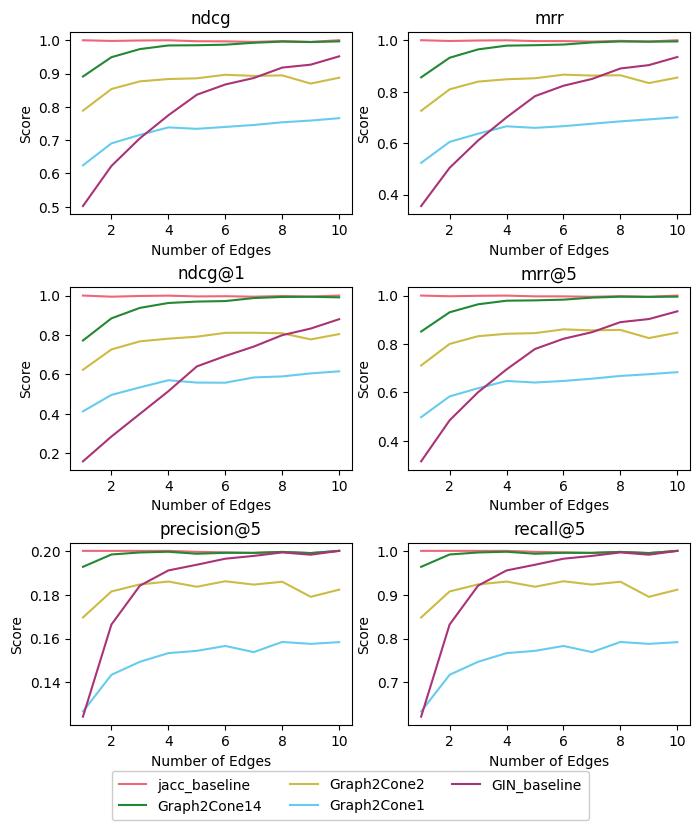

In [83]:
from matplotlib import pyplot as plt

data = model_dicts

# Set up the number of subplots (rows and columns)
n_metrics = len(metrics)
colors = ["#EE6677", "#228833", "#CCBB44", "#66CCEE", "#AA3377"]

# Set up the number of subplots (rows and columns)
cols = 2
rows = 3

# Create a figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(8, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

# Plot each metric
for idx, metric in enumerate(metrics):
    ax = axes[idx // cols, idx % cols]
    for model_idx, model in enumerate(models):
        ax.plot(range(1, 11), data[model][metric], label=model, color=colors[model_idx % len(colors)])
    ax.set_title(metric)
    ax.set_xlabel('Number of Edges')
    ax.set_ylabel('Score')

# Hide any empty subplots
for i in range(n_metrics, rows * cols):
    fig.delaxes(axes.flatten()[i])

# Create a shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=10, frameon=True, framealpha=1, fancybox=True, borderpad=0.5)
#fig.suptitle('Model Performance by Number of Queries (Easier)')

# Adjust layout to remove the gap
#plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()